In [1]:
import pandas as pd
import glob
import os
import numpy as np
import mne 
from matplotlib import pyplot as plt

from sklearn.decomposition import FastICA

In [2]:
dfs = []

for i_csv in sorted(glob.glob('./data/*.csv')):
    print(i_csv)
    dfs.append(pd.read_csv(i_csv))
    
df = pd.concat(dfs)
df.loc[df['sensor position']=='FP1', 'sensor position'] = 'Fp1'
df.loc[df['sensor position']=='FP2', 'sensor position'] = 'Fp2'
df.loc[df['sensor position']=='CZ', 'sensor position'] = 'Cz'
df.loc[df['sensor position']=='PZ', 'sensor position'] = 'Pz'
df.loc[df['sensor position']=='FZ', 'sensor position'] = 'Fz'

df

./data/Data1.csv
./data/Data2.csv
./data/Data3.csv
./data/Data4.csv
./data/Data5.csv
./data/Data6.csv
./data/Data7.csv
./data/Data8.csv


,Unnamed: 0,trial number,sensor position,sample num,sensor value,subject identifier,matching condition,channel,name,time
0,5,0,Fp1,0,-8.921,a,S1 obj,0,co2a0000364,0.000000
1,6,0,Fp1,1,-8.433,a,S1 obj,0,co2a0000364,0.003906
2,7,0,Fp1,2,-2.574,a,S1 obj,0,co2a0000364,0.007812
3,8,0,Fp1,3,5.239,a,S1 obj,0,co2a0000364,0.011719
4,9,0,Fp1,4,11.587,a,S1 obj,0,co2a0000364,0.015625
...,...,...,...,...,...,...,...,...,...,...
16379,16447,15,Y,251,1.292,a,"S2 nomatch,",63,co2a0000364,0.980469
16380,16448,15,Y,252,1.292,a,"S2 nomatch,",63,co2a0000364,0.984375
16381,16449,15,Y,253,-2.126,a,"S2 nomatch,",63,co2a0000364,0.988281
16382,16450,15,Y,254,-6.521,a,"S2 nomatch,",63,co2a0000364,0.992188


In [3]:
eeg_data = {}

for sensor in df['sensor position'].unique():
    eeg_data[sensor] = df[df['sensor position']==sensor]['sensor value'].values

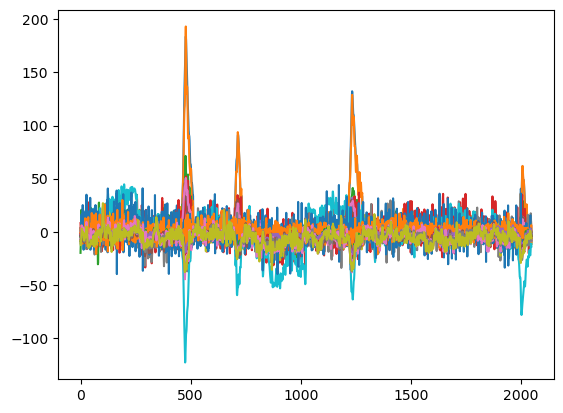

In [4]:
chans_1020 = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'C3', 'Cz', 
              'C4', 'P3', 'Pz', 'P4', 'T7', 'T8', 'P7', 'P8', 'O1', 'O2']

eeg = []
channel_names = []
for chan in eeg_data.keys():
    if chan in chans_1020:
        channel_names.append(chan)
        eeg.append(eeg_data[chan])
        
data = np.stack(eeg)

for i_sig in data:
    plt.plot(i_sig)
plt.show()

In [5]:
sf = 256

# make 1020
mne_info = mne.create_info(channel_names,
                           sf,
                           ch_types=['eeg']*len(channel_names)
                          )

mne_raw = mne.io.RawArray(data, mne_info)

standard_1020 = mne.channels.make_standard_montage('standard_1020')
mne_raw.set_montage(standard_1020)

Creating RawArray with float64 data, n_channels=19, n_times=2048
    Range : 0 ... 2047 =      0.000 ...     7.996 secs
Ready.


<RawArray | 19 x 2048 (8.0 s), ~336 kB, data loaded>

In [6]:
# interactive plot
# %matplotlib ipympl
# mne_raw.plot();

In [7]:
# i.e n_pca_components=10 to select n components and reduce ica algorithm complexity, 

ica_obj = mne.preprocessing.ICA(
                    n_components=19,
                    method='infomax',
                    max_iter="auto",
                    random_state=1,
                    fit_params=dict(extended=True)).fit(mne_raw)

Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 19 components
Computing Extended Infomax ICA


/var/folders/v2/dqfvq5td0xbbzc8vbm_gx0200000gn/T/ipykernel_19460/1586487011.py:3: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica_obj = mne.preprocessing.ICA(


Fitting ICA took 1.1s.


In [8]:
ica = ica_obj.get_sources(mne_raw).get_data()
ica.shape

(19, 2048)

In [9]:
ica_comps = ica_obj.get_components()

Creating RawArray with float64 data, n_channels=19, n_times=2048
    Range : 0 ... 2047 =      0.000 ...     7.996 secs
Ready.
Using matplotlib as 2D backend.


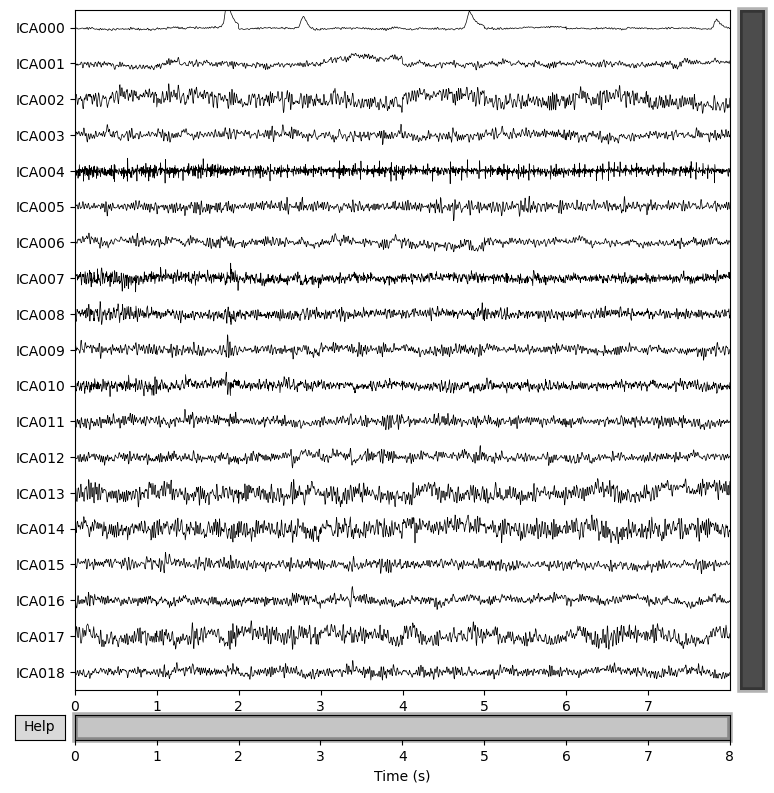

In [10]:
ica_obj.plot_sources(mne_raw);

In [11]:
from mne_icalabel import label_components
# https://labeling.ucsd.edu/tutorial/overview more on IC labeling

ic_labels = label_components(mne_raw, ica_obj, method="iclabel")
labels = ic_labels["labels"]
exclude = [idx for idx, label in enumerate(labels) if label not in ["brain", "other"]]

/var/folders/v2/dqfvq5td0xbbzc8vbm_gx0200000gn/T/ipykernel_19460/3927367912.py:4: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(mne_raw, ica_obj, method="iclabel")
/var/folders/v2/dqfvq5td0xbbzc8vbm_gx0200000gn/T/ipykernel_19460/3927367912.py:4: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(mne_raw, ica_obj, method="iclabel")


In [12]:
ic_labels

{'y_pred_proba': array([0.43462142, 0.6129894 , 0.9933257 , 0.53557646, 0.754913  ,
        0.9930454 , 0.3072959 , 0.4592619 , 0.705662  , 0.67711467,
        0.2575962 , 0.5923257 , 0.6161028 , 0.42241842, 0.8213485 ,
        0.9963741 , 0.7921406 , 0.5152909 , 0.7398394 ], dtype=float32),
 'labels': ['eye blink',
  'brain',
  'brain',
  'brain',
  'brain',
  'muscle artifact',
  'muscle artifact',
  'other',
  'muscle artifact',
  'other',
  'eye blink',
  'other',
  'brain',
  'heart beat',
  'other',
  'muscle artifact',
  'other',
  'muscle artifact',
  'channel noise']}

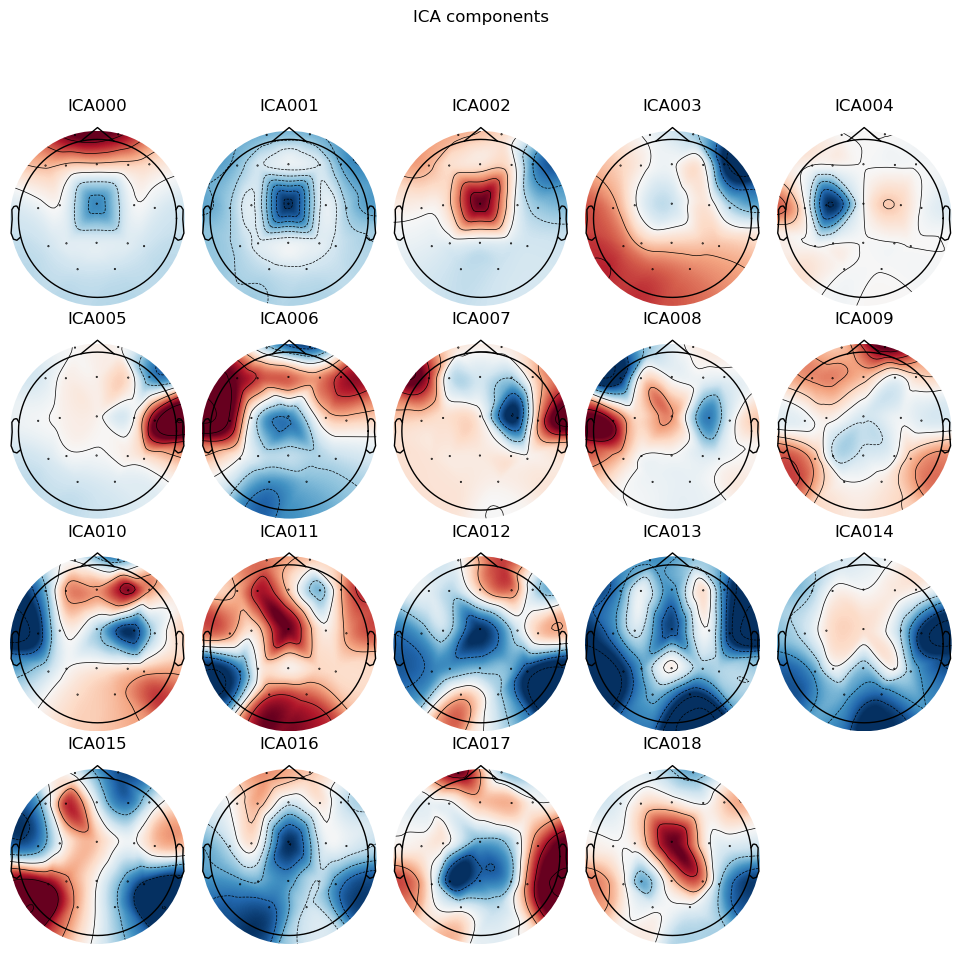

[<MNEFigure size 975x967 with 19 Axes>]

In [13]:
from ipywidgets import interact

# We can visualze the scalp dipole topography maps of each component using plot_components. 
# These are interpolated based on the values in the ICA mixing matrix:

ica_obj.plot_components(picks=None,show=True, inst=mne_raw)

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
4 matching events found
No baseline correction applied
0 projection items activated


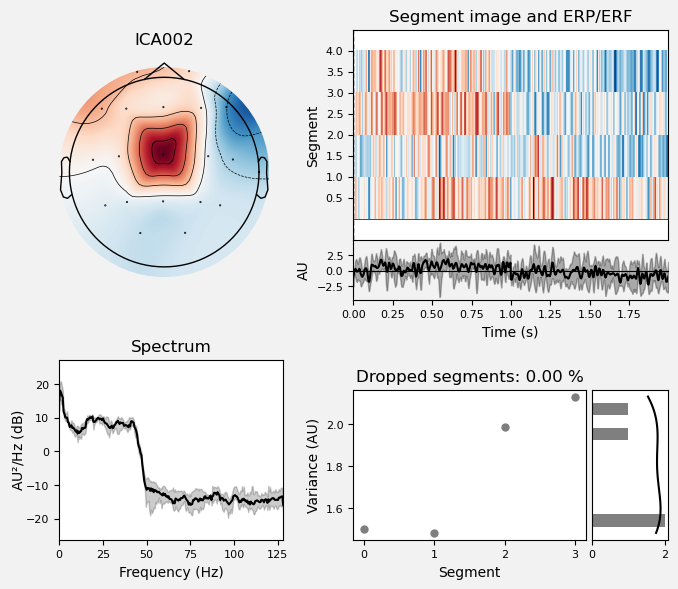

[<Figure size 700x600 with 6 Axes>]

In [14]:
# We can inspect the 'brain' components in more depth

ica_obj.plot_properties(mne_raw, picks=[2], show=True)

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
4 matching events found
No baseline correction applied
0 projection items activated


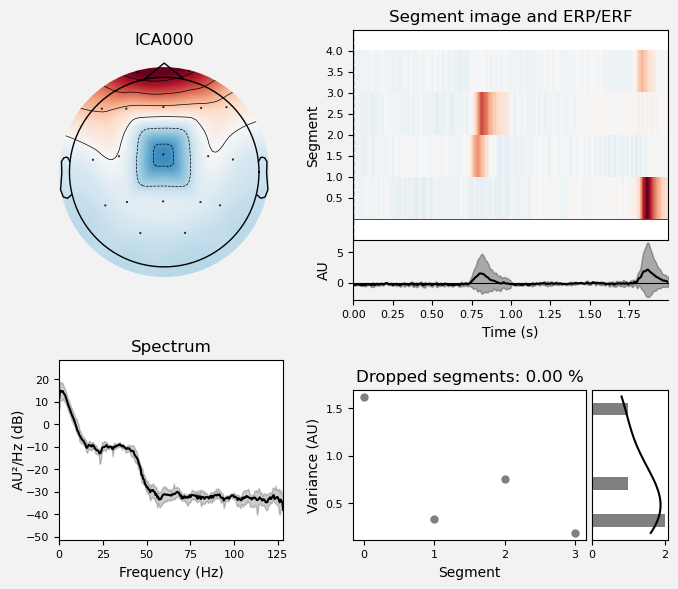

[<Figure size 700x600 with 6 Axes>]

In [15]:
# As well as the eye-blink component

ica_obj.plot_properties(mne_raw, picks=[0], show=True)